In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, spearmanr, pearsonr
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [163]:
df = pd.read_csv('../rotterdam.csv')
df = df.dropna()

In [164]:
CUTOFF_DAYS = 3650
df_clean = df.copy()

df['target'] = np.where((df['death'] == 1) & (df_clean['recur'] == 1) & (df_clean['dtime'] <= CUTOFF_DAYS), 1, 0)

valid_mask = (df['target'] == 1) | ((df['target'] == 0) & (df['dtime'] > CUTOFF_DAYS))
df_clean = df[valid_mask].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after filtering (follow-up >= 5y): {df_clean.shape}")

summary = pd.DataFrame({
    'Count': df_clean['target'].value_counts(),
    'Proportion': df_clean['target'].value_counts(normalize=True).round(3)
})
print("\Mortality rate summary:\n")
print(summary)

Original shape: (2982, 17)
Shape after filtering (follow-up >= 5y): (1349, 17)
\Mortality rate summary:

        Count  Proportion
target                   
0         685       0.508
1         664       0.492


In [165]:
df_clean['nodes_log'] = np.log1p(df_clean['nodes'])
df_clean['er_log'] = np.log1p(df_clean['er'])
df_clean['pgr_log'] = np.log1p(df_clean['pgr'])

# categorize ER and PGR into binary groups (0: <10, 1: >=10)
df_clean['er_cat'] = np.where(df_clean['er'] >= 10, 1, 0)
df_clean['pgr_cat'] = np.where(df_clean['pgr'] >= 10, 1, 0)

# Nodes as categorical groups: 0, 1-3, 4-9, 10+
node_bins = [-0.1, 0, 3, 9, np.inf]
node_labels = ['0', '1-3', '4-9', '10+']
df_clean['nodes_cat'] = pd.cut(df_clean['nodes'], bins=node_bins, labels=node_labels, right=True)

# ORDINAL encoding for nodes (0, 1, 2, 3 for the four categories)
nodes_ord_map = {'0': 0, '1-3': 1, '4-9': 2, '10+': 3}
df_clean['nodes_ord'] = df_clean['nodes_cat'].map(nodes_ord_map)

# grade: already ordinal (2 < 3)
# size: <=20, 20-50, >50 → map to 0, 1, 2
size_map = {'<=20': 0, '20-50': 1, '>50': 2}
df_clean['size_ord'] = df_clean['size'].map(size_map)

# age: binned into decades: (<40:0, 40-49:1, 50-59:2, 60-69:3, 70+:4)
age_bins = [0, 39, 49, 59, 69, np.inf]
age_labels = [0, 1, 2, 3, 4]
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

num_features = ['age', 'nodes_log', 'pgr_log', 'er_log', 'pgr', 'er']
ordinal_features = ['grade', 'size_ord', 'age_bin', 'nodes_ord']  # Treat as ordinal
cat_features = ['nodes_cat', 'er_cat', 'pgr_cat']  # Keep nodes_cat as nominal categorical

X = df_clean[num_features + ordinal_features + cat_features]
y = df_clean['target']

# Statistical Tests on Features for Mortality Prediction

**Tests performed:**
- **Mann-Whitney U test (non-parametric)**: Compares distributions of features between mortality and survival groups
- **Chi-Square test**: Tests association between categorical features and mortality outcome

In [166]:
# Separate features by type
cont_vars = ['age', 'nodes', 'er', 'pgr', 'nodes_log', 'er_log', 'pgr_log']
cat_vars = ['grade', 'size', 'meno', 'nodes_cat', 'er_cat', 'pgr_cat', 'size_ord', 'nodes_ord', 'age_bin']

# t-test is for parametric continuous variables, so we use Mann-Whitney U test for non-parametric continuous variables

print("\n--- Continuous Variables (Mann-Whitney U Test) ---")
for col in cont_vars:
    # Compare distributions between Death (1) and Survival (0)
    stat, p = mannwhitneyu(df_clean[df_clean['target']==1][col], df_clean[df_clean['target']==0][col])
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")

print("\n--- Categorical Variables (Chi-Square Test) ---")
for col in cat_vars:
    # Check dependency between category and target
    ct = pd.crosstab(df_clean[col], df_clean['target'])
    stat, p, _, _ = chi2_contingency(ct)
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")


--- Continuous Variables (Mann-Whitney U Test) ---
AGE: p=0.0002 (Significant)
NODES: p=0.0000 (Significant)
ER: p=0.5228 
PGR: p=0.0000 (Significant)
NODES_LOG: p=0.0000 (Significant)
ER_LOG: p=0.5228 
PGR_LOG: p=0.0000 (Significant)

--- Categorical Variables (Chi-Square Test) ---
GRADE: p=0.0000 (Significant)
SIZE: p=0.0000 (Significant)
MENO: p=0.0000 (Significant)
NODES_CAT: p=0.0000 (Significant)
ER_CAT: p=0.0426 (Significant)
PGR_CAT: p=0.0000 (Significant)
SIZE_ORD: p=0.0000 (Significant)
NODES_ORD: p=0.0000 (Significant)
AGE_BIN: p=0.0000 (Significant)


## 1. Descriptive Statistics by Mortality Status

In [167]:
print("\n" + "="*80)
print("NUMERICAL VARIABLES - Descriptive Statistics")
print("="*80)

numerical_vars = ['age', 'nodes', 'er', 'pgr', 'nodes_log', 'er_log', 'pgr_log']

desc_stats_num = []
for var in numerical_vars:
    died_yes = df_clean[y == 1][var]
    died_no = df_clean[y == 0][var]
    
    desc_stats_num.append({
        'Variable': var,
        'No Death (Mean±SD)': f"{died_no.mean():.2f}±{died_no.std():.2f}",
        'Death (Mean±SD)': f"{died_yes.mean():.2f}±{died_yes.std():.2f}",
        'No Death (Median[IQR])': f"{died_no.median():.2f}[{died_no.quantile(0.25):.2f}-{died_no.quantile(0.75):.2f}]",
        'Death (Median[IQR])': f"{died_yes.median():.2f}[{died_yes.quantile(0.25):.2f}-{died_yes.quantile(0.75):.2f}]"
    })

desc_stats_num_df = pd.DataFrame(desc_stats_num)
print(desc_stats_num_df.to_string(index=False))

print("\n" + "="*80)
print("CATEGORICAL VARIABLES - Descriptive Statistics")
print("="*80)

categorical_vars = ['grade', 'size', 'meno', 'nodes_cat', 'er_cat', 'pgr_cat', 'size_ord', 'nodes_ord', 'age_bin']

for var in categorical_vars:
    ct = pd.crosstab(df_clean[var], y, margins=False)
    prop = pd.crosstab(df_clean[var], y, normalize='index') * 100
    
    print(f"\n{var.upper()}:")
    print("\nRow Percentages:")
    print(prop.round(1).to_string())



NUMERICAL VARIABLES - Descriptive Statistics


 Variable No Death (Mean±SD) Death (Mean±SD) No Death (Median[IQR]) Death (Median[IQR])
      age        53.02±11.60     55.82±13.78     52.00[44.00-62.00]  56.00[45.00-67.00]
    nodes          1.55±3.37       6.12±5.90        0.00[0.00-2.00]    5.00[1.00-10.00]
       er      159.08±290.82   159.99±267.58    58.00[12.00-184.00]  52.00[7.00-203.00]
      pgr      209.39±360.68   119.39±243.79     62.00[8.00-238.00]  25.00[2.00-119.25]
nodes_log          0.54±0.77       1.55±0.99        0.00[0.00-1.10]     1.79[0.69-2.40]
   er_log          3.74±1.96       3.61±2.11        4.08[2.56-5.22]     3.97[2.08-5.32]
  pgr_log          3.73±2.25       3.01±2.17        4.14[2.20-5.48]     3.26[1.10-4.79]

CATEGORICAL VARIABLES - Descriptive Statistics

GRADE:

Row Percentages:
target     0     1
grade             
2       69.7  30.3
3       44.6  55.4

SIZE:

Row Percentages:
target     0     1
size              
20-50   42.0  58.0
<=20    72.0  28.0
>50     19.6  80.4

MENO:

Row Percentages:
t

## 4. Univariate Logistic Regression Analysis

Tests the association between each feature and mortality outcome.

In [168]:
print("\n" + "="*80)
print("UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)")
print("="*80)

logistic_results = []

# Numerical features
for var in numerical_vars:
    try:
        X_temp = df_clean[[var]].copy()
        X_temp = sm.add_constant(X_temp)
        
        model = sm.Logit(y, X_temp).fit(disp=0)
        
        coef = model.params[var]
        or_val = np.exp(coef)
        pval = model.pvalues[var]
        ci_lower = np.exp(coef - 1.96 * model.bse[var])
        ci_upper = np.exp(coef + 1.96 * model.bse[var])
        
        logistic_results.append({
            'Variable': var,
            'Coeff': f"{coef:.4f}",
            'OR': f"{or_val:.4f}",
            '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
            'P-value': f"{pval:.4f}",
            'Sig': '***' if pval < 0.05 else ''
        })
    except Exception as e:
        print(f"Skipping {var} (num): {e}")
        continue

# Categorical features (one-hot with reference)
for var in categorical_vars:
    try:
        dummies = pd.get_dummies(df_clean[var], prefix=var, drop_first=True, dtype=float)
        if dummies.empty:
            continue
        X_temp = sm.add_constant(dummies)
        model = sm.Logit(y.astype(float), X_temp).fit(disp=0)
        for col in dummies.columns:
            coef = model.params[col]
            or_val = np.exp(coef)
            pval = model.pvalues[col]
            ci_lower = np.exp(coef - 1.96 * model.bse[col])
            ci_upper = np.exp(coef + 1.96 * model.bse[col])
            level = col.replace(f"{var}_", "")
            logistic_results.append({
                'Variable': f"{var}={level}",
                'Coeff': f"{coef:.4f}",
                'OR': f"{or_val:.4f}",
                '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
                'P-value': f"{pval:.4f}",
                'Sig': '***' if pval < 0.05 else ''
            })
    except Exception as e:
        print(f"Skipping {var} (cat): {e}")
        continue

logistic_df = pd.DataFrame(logistic_results)
print(logistic_df.to_string(index=False))


UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)
     Variable   Coeff      OR             95% CI P-value Sig
          age  0.0173  1.0174   (1.0089, 1.0261)  0.0001 ***
        nodes  0.2526  1.2873   (1.2421, 1.3342)  0.0000 ***
           er  0.0000  1.0000   (0.9996, 1.0004)  0.9520    
          pgr -0.0011  0.9989   (0.9985, 0.9993)  0.0000 ***
    nodes_log  1.1558  3.1765   (2.7746, 3.6366)  0.0000 ***
       er_log -0.0311  0.9694   (0.9198, 1.0217)  0.2467    
      pgr_log -0.1451  0.8649   (0.8237, 0.9082)  0.0000 ***
      grade=3  1.0490  2.8548   (2.1916, 3.7187)  0.0000 ***
    size=<=20 -1.2698  0.2809   (0.2196, 0.3593)  0.0000 ***
     size=>50  1.0903  2.9751   (1.9917, 4.4441)  0.0000 ***
       meno=1  0.4553  1.5767   (1.2702, 1.9571)  0.0000 ***
nodes_cat=1-3  0.9209  2.5114   (1.8757, 3.3627)  0.0000 ***
nodes_cat=4-9  2.2389  9.3835  (6.7020, 13.1378)  0.0000 ***
nodes_cat=10+  2.9841 19.7694 (12.6033, 31.0101)  0.0000 ***
     er_cat=1 -0.2631  0.7687   (0.6004

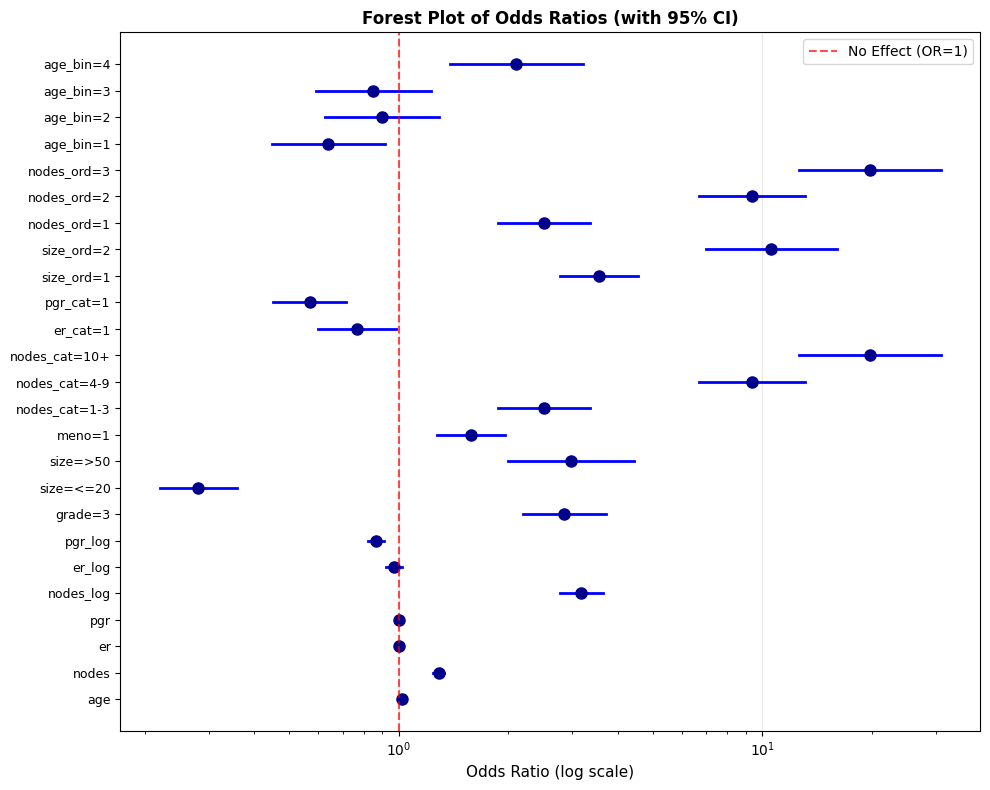

In [169]:
# Extract data for forest plot
forest_data = []
for result in logistic_results:
    var = result['Variable']
    or_val = float(result['OR'])
    ci_str = result['95% CI'].strip('()')
    ci_lower, ci_upper = map(float, ci_str.split(', '))
    forest_data.append({
        'Variable': var,
        'OR': or_val,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper
    })

forest_df = pd.DataFrame(forest_data)

# Create forest plot
fig, ax = plt.subplots(figsize=(10, max(8, len(forest_df)*0.25)))

y_pos = np.arange(len(forest_df))

# Plot confidence intervals
for i, (_, row) in enumerate(forest_df.iterrows()):
    ax.plot([row['CI_Lower'], row['CI_Upper']], [i, i], 'b-', linewidth=2)
    ax.plot(row['OR'], i, 'o', color='darkblue', markersize=8)

# Add vertical line at OR = 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='No Effect (OR=1)')

ax.set_yticks(y_pos)
ax.set_yticklabels(forest_df['Variable'], fontsize=9)
ax.set_xlabel('Odds Ratio (log scale)', fontsize=11)
ax.set_title('Forest Plot of Odds Ratios (with 95% CI)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(loc='best')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 5. Correlation Analysis

Spearman correlation for examining relationships between continuous variables and mortality outcome.

In [170]:
print("\n" + "="*80)
print("CORRELATION WITH DEATH OUTCOME")
print("="*80)

correlation_results = []

for var in numerical_vars:
    spear_corr, spear_pval = spearmanr(df_clean[var].dropna(), y[df_clean[var].notna()])
    
    correlation_results.append({
        'Variable': var,
        'Spearman ρ': f"{spear_corr:.4f}",
        'Spearman p-val': f"{spear_pval:.4f}",
    })

corr_df = pd.DataFrame(correlation_results)
print(corr_df.to_string(index=False))


CORRELATION WITH DEATH OUTCOME
 Variable Spearman ρ Spearman p-val
      age     0.1025         0.0002
    nodes     0.4956         0.0000
       er    -0.0174         0.5229
      pgr    -0.1665         0.0000
nodes_log     0.4956         0.0000
   er_log    -0.0174         0.5229
  pgr_log    -0.1665         0.0000


## 6. Multicollinearity Check (VIF Analysis)

In [171]:
print("\n" + "="*80)
print("VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check")
print("="*80)

# Calculate VIF for numerical features
X_vif = df_clean[numerical_vars].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_vars
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(numerical_vars))]

print(vif_data.to_string(index=False))


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
 Variable      VIF
      age 1.174620
    nodes 5.602188
       er 1.872790
      pgr 1.868511
nodes_log 5.646475
   er_log 2.520698
  pgr_log 2.492342


## KEY FINDINGS:

In [172]:
%pip install mlxtend
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# --- Feature Selection Functions (NO internal CV) ---

def forward_selection(X_train, y_train):
    sfs_forward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='forward',
        scoring='roc_auc',
        cv=2,  # Minimal internal CV just for selection
        n_jobs=-1
    )
    sfs_forward.fit(X_train, y_train)
    fwd_idx = sfs_forward.get_support()
    return fwd_idx

def backward_elimination(X_train, y_train):
    sfs_backward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='backward',
        scoring='roc_auc',
        cv=2,  # Minimal internal CV just for selection
        n_jobs=-1
    )
    sfs_backward.fit(X_train, y_train)
    bwd_idx = sfs_backward.get_support()
    return bwd_idx

def best_subset_selection(X_train, y_train, max_features=8):
    from itertools import combinations
    feature_list = list(range(X_train.shape[1]))
    best_score = -np.inf
    best_idx = []
    
    for k in range(1, min(max_features, len(feature_list)) + 1):
        for combo in combinations(feature_list, k):
            X_subset = X_train[:, combo]
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
            model.fit(X_subset, y_train)
            y_prob = model.predict_proba(X_subset)[:, 1]
            score = roc_auc_score(y_train, y_prob)
            
            if score > best_score:
                best_score = score
                best_idx = list(combo)
    
    # Convert to boolean mask
    mask = np.zeros(X_train.shape[1], dtype=bool)
    mask[best_idx] = True
    return mask

Note: you may need to restart the kernel to use updated packages.


In [173]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Define Features
numerical = ['er_log', 'pgr_log']
ordinal = ['grade', 'size_ord', 'age_bin', 'nodes_ord']

# 2. Define Pipelines
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

ord_pipe = Pipeline([
    ('scaler', MinMaxScaler())
])

cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))
])

# 3. Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numerical),
        ('ord', ord_pipe, ordinal),
    ],
    verbose_feature_names_out=False
)

features = numerical + ordinal

In [174]:
# --- Prepare Data and Preprocess ---
from sklearn.model_selection import train_test_split

# Prepare Data with corrected features (nodes_ord instead of nodes_cat)
X = df_clean[features]
y = df_clean['target']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

# Preprocess (fit on TRAIN only)
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrames for easier feature selection
X_train_df = pd.DataFrame(X_train_proc, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_proc, columns=feature_names, index=X_test.index)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Processed features: {', '.join(feature_names)}")
print(f"Total features: {len(feature_names)}\n")

Training set size: 1079
Test set size: 270
Processed features: er_log, pgr_log, grade, size_ord, age_bin, nodes_ord
Total features: 6



In [175]:
# --- PROPER K-FOLD CROSS-VALIDATION FOR FEATURE SELECTION ---
import time
from itertools import combinations
from collections import defaultdict

print("=" * 80)
print("K-FOLD CROSS-VALIDATION WITH FEATURE SELECTION")
print("=" * 80 + "\n")

# Setup K-fold CV
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1234)

# Storage for results across folds
fold_results = {
    'forward': defaultdict(list),
    'backward': defaultdict(list),
    'best_subset': defaultdict(list)
}

feature_counts = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

selected_features_per_fold = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

print(f"Performing {n_folds}-Fold Cross-Validation...\n")

# Perform K-fold CV
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_df, y_train), 1):
    print(f"Fold {fold_idx}/{n_folds}...")
    
    # Split data for this fold
    X_fold_train = X_train_df.iloc[train_idx].values
    y_fold_train = y_train.iloc[train_idx].values
    X_fold_val = X_train_df.iloc[val_idx].values
    y_fold_val = y_train.iloc[val_idx].values
    
    # --- FORWARD SELECTION ---
    try:
        fwd_mask = forward_selection(X_fold_train, y_fold_train)
        fwd_features = X_train_df.columns[fwd_mask].tolist()
        feature_counts['forward'].append(len(fwd_features))
        selected_features_per_fold['forward'].append(fwd_features)
        
        if len(fwd_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, fwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, fwd_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['forward']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results['forward']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results['forward']['f1'].append(f1_score(y_fold_val, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results['forward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Forward: {len(fwd_features)} features, AUC={fold_results['forward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Forward selection failed: {e}")
    
    # --- BACKWARD ELIMINATION ---
    try:
        bwd_mask = backward_elimination(X_fold_train, y_fold_train)
        bwd_features = X_train_df.columns[bwd_mask].tolist()
        feature_counts['backward'].append(len(bwd_features))
        selected_features_per_fold['backward'].append(bwd_features)
        
        if len(bwd_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, bwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, bwd_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['backward']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results['backward']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results['backward']['f1'].append(f1_score(y_fold_val, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results['backward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Backward: {len(bwd_features)} features, AUC={fold_results['backward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Backward elimination failed: {e}")
    
    # --- BEST SUBSET SELECTION ---
    try:
        best_mask = best_subset_selection(X_fold_train, y_fold_train, max_features=8)
        best_features = X_train_df.columns[best_mask].tolist()
        feature_counts['best_subset'].append(len(best_features))
        selected_features_per_fold['best_subset'].append(best_features)
        
        if len(best_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, best_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val[:, best_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['best_subset']['auc'].append(roc_auc_score(y_fold_val, y_prob))
            fold_results['best_subset']['accuracy'].append(accuracy_score(y_fold_val, y_pred))
            fold_results['best_subset']['f1'].append(f1_score(y_fold_val, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val, y_prob)
            fold_results['best_subset']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Best Subset: {len(best_features)} features, AUC={fold_results['best_subset']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Best subset selection failed: {e}")
    
    print()

# --- AGGREGATE RESULTS ACROSS FOLDS ---
print("=" * 80)
print("CROSS-VALIDATION RESULTS (Mean ± Std across folds)")
print("=" * 80 + "\n")

cv_summary = []
for method_name in ['forward', 'backward', 'best_subset']:
    if len(fold_results[method_name]['auc']) > 0:
        cv_summary.append({
            'Method': method_name.replace('_', ' ').title(),
            'Avg Features': f"{np.mean(feature_counts[method_name]):.1f} ± {np.std(feature_counts[method_name]):.1f}",
            'ROC-AUC': f"{np.mean(fold_results[method_name]['auc']):.4f} ± {np.std(fold_results[method_name]['auc']):.4f}",
            'PR-AUC': f"{np.mean(fold_results[method_name]['pr_auc']):.4f} ± {np.std(fold_results[method_name]['pr_auc']):.4f}",
            'Accuracy': f"{np.mean(fold_results[method_name]['accuracy']):.4f} ± {np.std(fold_results[method_name]['accuracy']):.4f}",
            'F1-Score': f"{np.mean(fold_results[method_name]['f1']):.4f} ± {np.std(fold_results[method_name]['f1']):.4f}"
        })

cv_summary_df = pd.DataFrame(cv_summary)
print(cv_summary_df.to_string(index=False))

# --- MOST FREQUENTLY SELECTED FEATURES ---
print("\n" + "=" * 80)
print("MOST FREQUENTLY SELECTED FEATURES ACROSS FOLDS")
print("=" * 80 + "\n")

for method_name in ['forward', 'backward', 'best_subset']:
    if len(selected_features_per_fold[method_name]) > 0:
        all_features = [feat for fold_feats in selected_features_per_fold[method_name] for feat in fold_feats]
        feature_freq = pd.Series(all_features).value_counts()
        
        print(f"{method_name.replace('_', ' ').title()}:")
        for feat, count in feature_freq.items():
            print(f"  {feat}: {count}/{n_folds} folds ({count/n_folds*100:.1f}%)")
        print()

# --- RETRAIN BEST METHOD ON FULL TRAINING DATA ---
# Select method with highest mean ROC-AUC
best_method = max(fold_results.keys(), 
                  key=lambda m: np.mean(fold_results[m]['auc']) if len(fold_results[m]['auc']) > 0 else -1)

print("=" * 80)
print(f"BEST METHOD: {best_method.replace('_', ' ').title()}")
print("=" * 80)
print(f"Mean ROC-AUC: {np.mean(fold_results[best_method]['auc']):.4f}")
print(f"Mean PR-AUC: {np.mean(fold_results[best_method]['pr_auc']):.4f}\n")

# Select most frequently chosen features for the best method
all_features_best = [feat for fold_feats in selected_features_per_fold[best_method] for feat in fold_feats]
feature_freq_best = pd.Series(all_features_best).value_counts()
# Keep features that appear in at least 3 out of 5 folds
final_features = feature_freq_best[feature_freq_best >= 3].index.tolist()

print(f"Final features (appearing in ≥3 folds): {', '.join(final_features)}")

# Store for later use
fwd_features = final_features if best_method == 'forward' else []
bwd_features = final_features if best_method == 'backward' else []
best_features = final_features if best_method == 'best_subset' else []

# Ensure variables exist for plotting
if best_method == 'forward':
    bwd_features = selected_features_per_fold['backward'][0] if len(selected_features_per_fold['backward']) > 0 else []
    best_features = selected_features_per_fold['best_subset'][0] if len(selected_features_per_fold['best_subset']) > 0 else []
elif best_method == 'backward':
    fwd_features = selected_features_per_fold['forward'][0] if len(selected_features_per_fold['forward']) > 0 else []
    best_features = selected_features_per_fold['best_subset'][0] if len(selected_features_per_fold['best_subset']) > 0 else []
else:
    fwd_features = selected_features_per_fold['forward'][0] if len(selected_features_per_fold['forward']) > 0 else []
    bwd_features = selected_features_per_fold['backward'][0] if len(selected_features_per_fold['backward']) > 0 else []

# Train final models on full training data for plotting
y_prob_fwd_test = None
y_prob_bwd_test = None
y_prob_best_test = None

if len(fwd_features) > 0:
    X_train_sel = sm.add_constant(X_train_df[fwd_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test_df[fwd_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train)
    y_prob_fwd_test = model.predict_proba(X_test_sel)[:, 1]

if len(bwd_features) > 0:
    X_train_sel = sm.add_constant(X_train_df[bwd_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test_df[bwd_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train)
    y_prob_bwd_test = model.predict_proba(X_test_sel)[:, 1]

if len(best_features) > 0:
    X_train_sel = sm.add_constant(X_train_df[best_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test_df[best_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train)
    y_prob_best_test = model.predict_proba(X_test_sel)[:, 1]



K-FOLD CROSS-VALIDATION WITH FEATURE SELECTION

Performing 5-Fold Cross-Validation...

Fold 1/5...
  Forward: 3 features, AUC=0.7697
  Backward: 3 features, AUC=0.7697
  Best Subset: 5 features, AUC=0.7853

Fold 2/5...
  Forward: 3 features, AUC=0.7658
  Backward: 3 features, AUC=0.7658
  Best Subset: 5 features, AUC=0.7650

Fold 3/5...
  Forward: 3 features, AUC=0.8555
  Backward: 3 features, AUC=0.8555
  Best Subset: 5 features, AUC=0.8662

Fold 4/5...
  Forward: 3 features, AUC=0.7813
  Backward: 3 features, AUC=0.7813
  Best Subset: 5 features, AUC=0.7964

Fold 5/5...
  Forward: 3 features, AUC=0.8002
  Backward: 3 features, AUC=0.8002
  Best Subset: 5 features, AUC=0.8102

CROSS-VALIDATION RESULTS (Mean ± Std across folds)

     Method Avg Features         ROC-AUC          PR-AUC        Accuracy        F1-Score
    Forward    3.0 ± 0.0 0.7945 ± 0.0328 0.7926 ± 0.0325 0.7359 ± 0.0231 0.7200 ± 0.0280
   Backward    3.0 ± 0.0 0.7945 ± 0.0328 0.7926 ± 0.0325 0.7359 ± 0.0231 0.7200 ± 

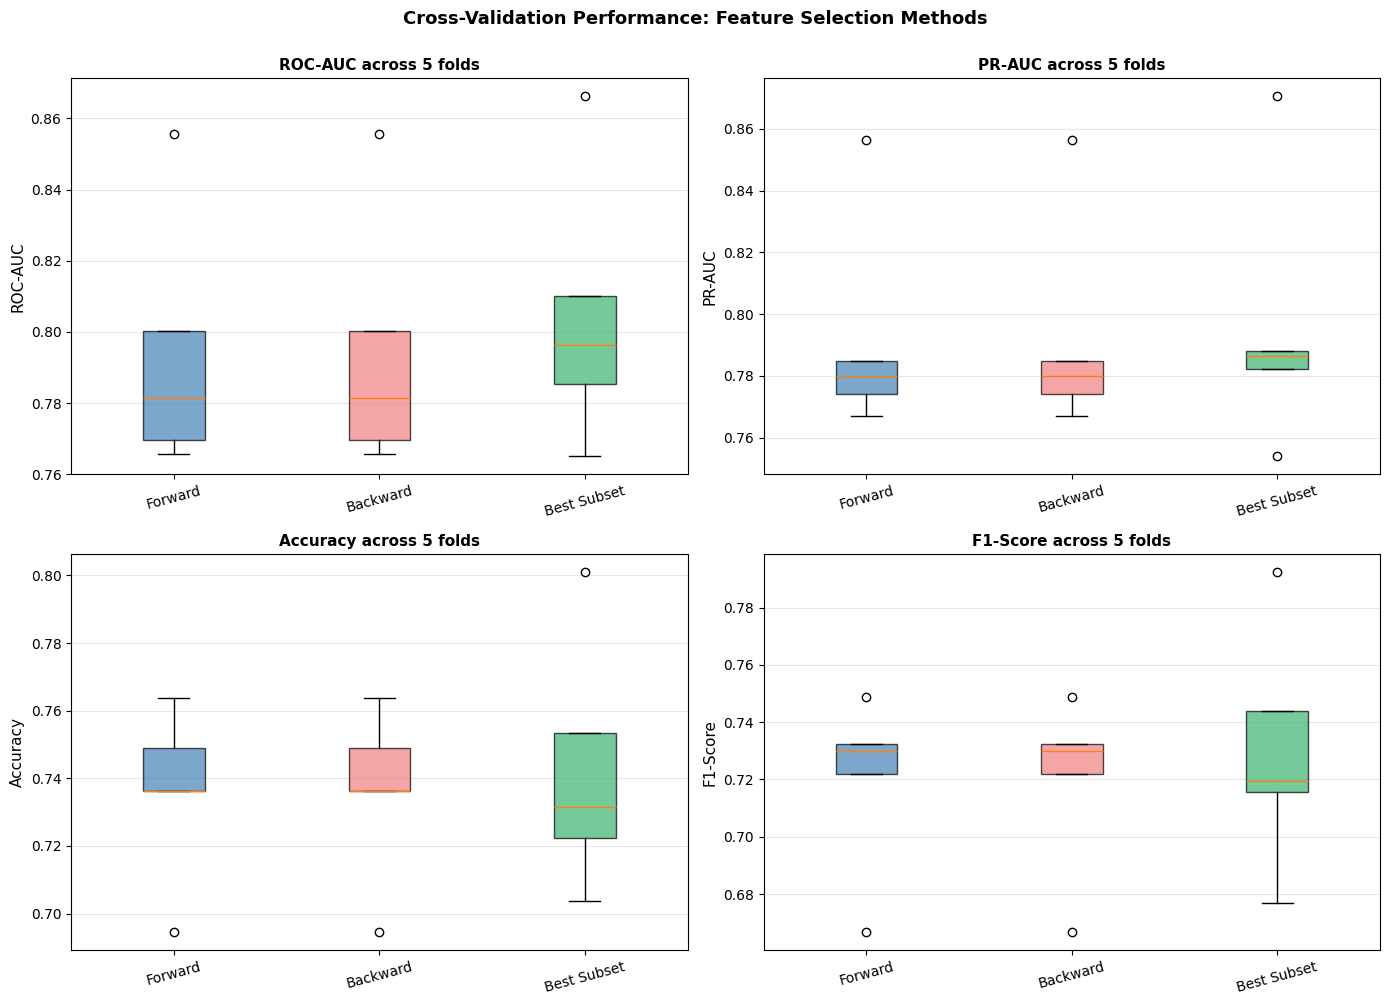

In [180]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['auc', 'pr_auc', 'accuracy', 'f1']
metric_labels = ['ROC-AUC', 'PR-AUC', 'Accuracy', 'F1-Score']
colors = ['steelblue', 'lightcoral', 'mediumseagreen']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    box_data = []
    box_labels = []
    
    for method_name in ['forward', 'backward', 'best_subset']:
        if len(fold_results[method_name][metric]) > 0:
            box_data.append(fold_results[method_name][metric])
            box_labels.append(method_name.replace('_', ' ').title())
    
    if box_data:
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_ylabel(label, fontsize=11)
        ax.set_title(f'{label} across {n_folds} folds', fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)

plt.suptitle('Cross-Validation Performance: Feature Selection Methods', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

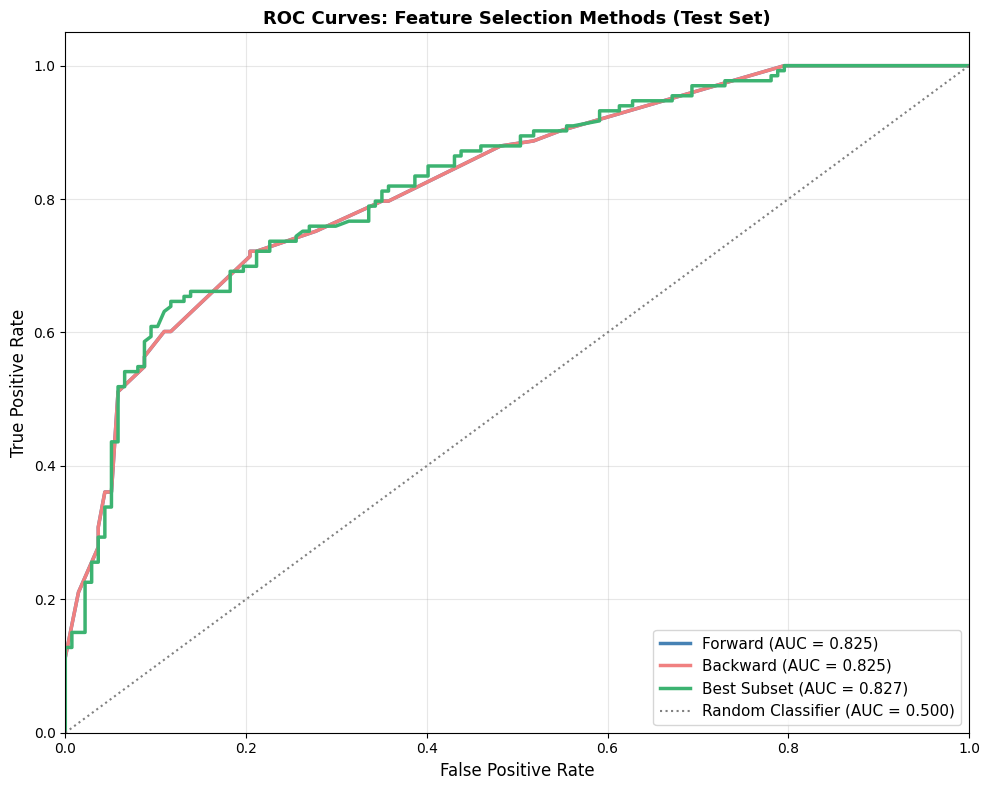


TEST SET PERFORMANCE SUMMARY

     Method  Features ROC-AUC PR-AUC Accuracy Precision Recall F1-Score
    Forward         3  0.8251 0.8294   0.7593    0.7742 0.7218   0.7471
   Backward         3  0.8251 0.8294   0.7593    0.7742 0.7218   0.7471
Best Subset         5  0.8270 0.8249   0.7519    0.7661 0.7143   0.7393



In [181]:
fig, ax = plt.subplots(figsize=(10, 8))

colors_roc = {'forward': 'steelblue', 'backward': 'lightcoral', 'best_subset': 'mediumseagreen'}

# Plot ROC for each method
for method_name in ['forward', 'backward', 'best_subset']:
    y_prob = None
    
    if method_name == 'forward' and y_prob_fwd_test is not None:
        y_prob = y_prob_fwd_test
    elif method_name == 'backward' and y_prob_bwd_test is not None:
        y_prob = y_prob_bwd_test
    elif method_name == 'best_subset' and y_prob_best_test is not None:
        y_prob = y_prob_best_test
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        ax.plot(fpr, tpr, 
               color=colors_roc[method_name],
               linewidth=2.5,
               label=f'{method_name.replace("_", " ").title()} (AUC = {roc_auc:.3f})')

# Plot random classifier
ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle=':', 
        label='Random Classifier (AUC = 0.500)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Feature Selection Methods (Test Set)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# 6. Summary table with test set performance
print("\n" + "=" * 80)
print("TEST SET PERFORMANCE SUMMARY")
print("=" * 80 + "\n")

test_summary = []

for method_name in ['forward', 'backward', 'best_subset']:
    y_prob = None
    features = []
    
    if method_name == 'forward' and y_prob_fwd_test is not None:
        y_prob = y_prob_fwd_test
        features = fwd_features
    elif method_name == 'backward' and y_prob_bwd_test is not None:
        y_prob = y_prob_bwd_test
        features = bwd_features
    elif method_name == 'best_subset' and y_prob_best_test is not None:
        y_prob = y_prob_best_test
        features = best_features
    
    if y_prob is not None and len(features) > 0:
        y_pred = (y_prob >= 0.5).astype(int)
        
        # Calculate metrics
        test_auc = roc_auc_score(y_test, y_prob)
        test_acc = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        
        # PR-AUC
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        test_pr_auc = auc(recall_vals, precision_vals)
        
        test_summary.append({
            'Method': method_name.replace('_', ' ').title(),
            'Features': len(features),
            'ROC-AUC': f"{test_auc:.4f}",
            'PR-AUC': f"{test_pr_auc:.4f}",
            'Accuracy': f"{test_acc:.4f}",
            'Precision': f"{test_precision:.4f}",
            'Recall': f"{test_recall:.4f}",
            'F1-Score': f"{test_f1:.4f}"
        })

test_summary_df = pd.DataFrame(test_summary)
print(test_summary_df.to_string(index=False))
print("\n" + "=" * 80)

In [176]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve

# Find best F1 threshold using the best method's predictions
if best_method == 'forward' and y_prob_fwd_test is not None:
	y_prob_final = y_prob_fwd_test
	method_name = 'Forward Selection'
elif best_method == 'backward' and y_prob_bwd_test is not None:
	y_prob_final = y_prob_bwd_test
	method_name = 'Backward Elimination'
elif best_method == 'best_subset' and y_prob_best_test is not None:
	y_prob_final = y_prob_best_test
	method_name = 'Best Subset Selection'
else:
	# Fallback to the most available probabilities
	if y_prob_fwd_test is not None:
		y_prob_final = y_prob_fwd_test
		method_name = 'Forward Selection'
	elif y_prob_bwd_test is not None:
		y_prob_final = y_prob_bwd_test
		method_name = 'Backward Elimination'
	else:
		y_prob_final = y_prob_best_test
		method_name = 'Best Subset Selection'

# Calculate F1 scores for different thresholds to find the best one
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_final)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
best_f1_threshold = thresholds[best_f1_idx]

# Generate predictions using best F1 threshold
y_pred_final = (y_prob_final >= best_f1_threshold).astype(int)

# Print best threshold
print(f"Best F1 threshold: {best_f1_threshold:.2f}")
print(f"Selected method: {method_name}\n")

# Print classification report
print("Classification Report (Best F1 Threshold):")
print(classification_report(y_test, y_pred_final, digits=3))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred_final)
print("Confusion Matrix:")
print(cm)


Best F1 threshold: 0.34
Selected method: Best Subset Selection

Classification Report (Best F1 Threshold):
              precision    recall  f1-score   support

           0      0.804     0.599     0.686       137
           1      0.673     0.850     0.751       133

    accuracy                          0.722       270
   macro avg      0.738     0.724     0.719       270
weighted avg      0.739     0.722     0.718       270

Confusion Matrix:
[[ 82  55]
 [ 20 113]]


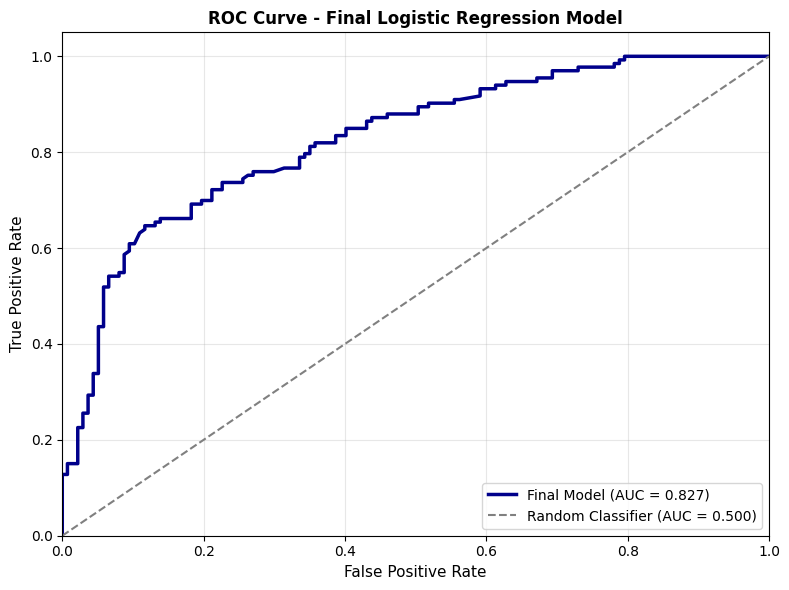

In [177]:
plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, y_prob_final)
roc_auc = roc_auc_score(y_test, y_prob_final)

plt.plot(fpr, tpr, color='darkblue', lw=2.5, label=f'Final Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve - Final Logistic Regression Model', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

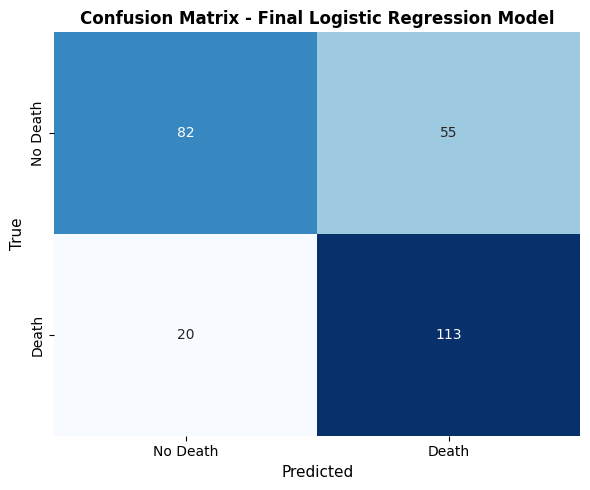

In [178]:
# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Death', 'Death'],
            yticklabels=['No Death', 'Death'])
plt.xlabel('Predicted', fontsize=11)
plt.ylabel('True', fontsize=11)
plt.title('Confusion Matrix - Final Logistic Regression Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

Now we'll perform hyperparameter tuning using GridSearchCV to optimize:
- **Penalty**: L1, L2, Elasticnet, or None
- **C**: Regularization strength (inverse)
- **Solver**: Different optimization algorithms
- **Class weights**: To handle class imbalance

In [ ]:
from sklearn.model_selection import GridSearchCV

print("=" * 80)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("=" * 80 + "\n")

# Define parameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],  # saga supports all penalties
    'class_weight': [None, 'balanced'],
    'max_iter': [1000]
}

# Storage for tuned models
tuned_results = {}

# Hyperparameter tuning for each feature selection method
for method_name in ['forward', 'backward', 'best_subset']:
    print(f"\n{method_name.replace('_', ' ').title()}:")
    print("-" * 80)
    
    # Get features from the method
    if method_name == 'forward' and len(fwd_features) > 0:
        features = fwd_features
    elif method_name == 'backward' and len(bwd_features) > 0:
        features = bwd_features
    elif method_name == 'best_subset' and len(best_features) > 0:
        features = best_features
    else:
        print(f"  No features available for {method_name}")
        continue
    
    print(f"  Features: {', '.join(features)}")
    
    # Prepare data with selected features (add constant for statsmodels compatibility)
    X_train_sel = X_train_df[features].values
    X_test_sel = X_test_df[features].values
    
    # GridSearchCV with 5-fold CV
    grid_search = GridSearchCV(
        LogisticRegression(random_state=1234),
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    print("  Running GridSearchCV (this may take a moment)...")
    grid_search.fit(X_train_sel, y_train)
    
    # Best parameters
    print(f"\n  Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"    {param}: {value}")
    print(f"  Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_model = grid_search.best_estimator_
    y_prob_tuned = best_model.predict_proba(X_test_sel)[:, 1]
    y_pred_tuned = best_model.predict(X_test_sel)
    
    # Calculate all metrics
    test_auc = roc_auc_score(y_test, y_prob_tuned)
    test_acc = accuracy_score(y_test, y_pred_tuned)
    test_f1 = f1_score(y_test, y_pred_tuned)
    test_precision = precision_score(y_test, y_pred_tuned)
    test_recall = recall_score(y_test, y_pred_tuned)
    
    # PR-AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob_tuned)
    test_pr_auc = auc(recall_vals, precision_vals)
    
    print(f"\n  Test Set Performance:")
    print(f"    ROC-AUC: {test_auc:.4f}")
    print(f"    PR-AUC: {test_pr_auc:.4f}")
    print(f"    Accuracy: {test_acc:.4f}")
    print(f"    Precision: {test_precision:.4f}")
    print(f"    Recall: {test_recall:.4f}")
    print(f"    F1-Score: {test_f1:.4f}")
    
    # Store results
    tuned_results[method_name] = {
        'model': best_model,
        'features': features,
        'params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'y_prob': y_prob_tuned,
        'y_pred': y_pred_tuned,
        'metrics': {
            'roc_auc': test_auc,
            'pr_auc': test_pr_auc,
            'accuracy': test_acc,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1
        }
    }

print("\n" + "=" * 80)

HYPERPARAMETER TUNING WITH GRIDSEARCHCV


Forward:
--------------------------------------------------------------------------------
  Features: age_bin, size_ord, nodes_ord
  Running GridSearchCV (this may take a moment)...

  Best Parameters:
    C: 0.001
    class_weight: balanced
    max_iter: 1000
    penalty: None
    solver: saga
  Best CV ROC-AUC: 0.7779

  Test Set Performance:
    ROC-AUC: 0.7940
    PR-AUC: 0.7142
    Accuracy: 0.7197
    Precision: 0.5581
    Recall: 0.7643
    F1-Score: 0.6452

Backward:
--------------------------------------------------------------------------------
  Features: age_bin, size_ord, nodes_ord
  Running GridSearchCV (this may take a moment)...

  Best Parameters:
    C: 0.001
    class_weight: balanced
    max_iter: 1000
    penalty: None
    solver: saga
  Best CV ROC-AUC: 0.7779

  Test Set Performance:
    ROC-AUC: 0.7940
    PR-AUC: 0.7142
    Accuracy: 0.7197
    Precision: 0.5581
    Recall: 0.7643
    F1-Score: 0.6452

Best Subset:
----